# 시계열 예측(Time-Series Prediction)

## 목표

- 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
- ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.

### 1. 시계열이란?

- 시간 순서대로 발생한 데이터의 수열
- 일정 시간 간격으로 발생한 데이터일 때가 많지만 꼭 그래야 하는 것은 아니다.

### 2. 미래 예측이 가능할까?

- 사실 불가능하다.
- 그럼에도 불구하고 미래 데이터를 예측하려면 다음 두 가지 전제가 필요하다.
    - 1) 과거의 데이터에 일정한 패턴이 발견된다.
    - 2) 과거 패턴은 미래에도 동일하게 반복될 것이다.
    
- 위 두 전제는 곧 '안정적(Stationary)' 데이터를 의미한다.
- 즉, stationary란 시계열 데이터의 통계적 특성이 변하지 않는다는 뜻
- 시간의 변화에 무관하게 일정한 프로세스가 존재한다는 뜻.

### 3. Stationary Time-series Data

- 정상 시계열 데이터에서 시간의 추이와 관계 없이 일정해야 하는 통계적 특성 세 가지
    - 1) 평균
    - 2) 분산
    - 3) 공분산 (정확히는 자기공분산)
    
- Covariance가 X, Y 변수의 단위 크기에 영향을 받기 때문에 그 값 자체가 두 변수 간의 상관성을 직접적으로 대표하지 못한다.
- 그래서 Covariance를 Normalize하여(두 변수의 표준편차의 곱으로 나눠서) 두 변수 간의 상관성이 항상 -1에서 1 사이의 값 으로 표현되도록 보정한 것이 Correlation이다.
- 두 확률변수 X, Y가 서로 독립이면 Covariance와 Correlation은 모두 0이다.
- 자기공분산이란?
    - X(t)와 X(t) 사이의 공분산이 아니라 X(t)와 X(t+h) 사이의 공분산
    - 즉 일정 시차 h 사이를 둔 자기자신과의 공분산

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6  

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# Google Drive Mount
# from google.colab import drive
# drive.mount('/content/drive')
# dir_path = 'drive/My Drive/Colab Notebooks/E14_time_series_prediction/daily-minimum-temperatures.csv'

Mounted at /content/drive


In [5]:
# Load dataset
dir_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E14_stock_prediction/data/daily-min-temperatures.csv'

df = pd.read_csv(dir_path, index_col='Date', parse_dates=True, error_bad_lines=False)
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [6]:
# Time Series 생성
ts1 = df['Temp']

ts1.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

<hr>

## 시계열 안정성의 정성적 분석

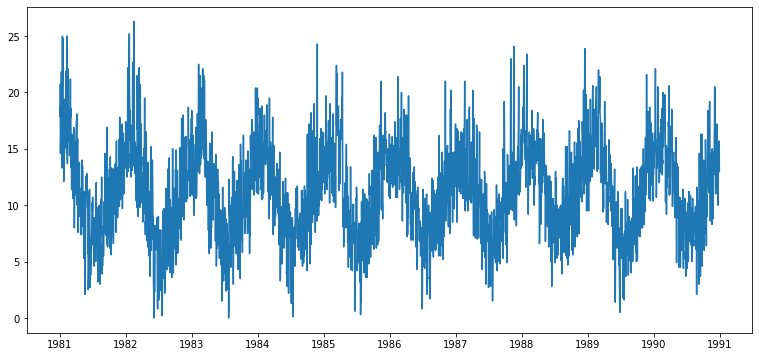

In [7]:
plt.plot(ts1)

### 결측치 보간(Interpolate)

- 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입

In [8]:
# 결측치만 출력
ts1[ts1.isna()]

Series([], Name: Temp, dtype: float64)

Series([], Name: Temp, dtype: float64)


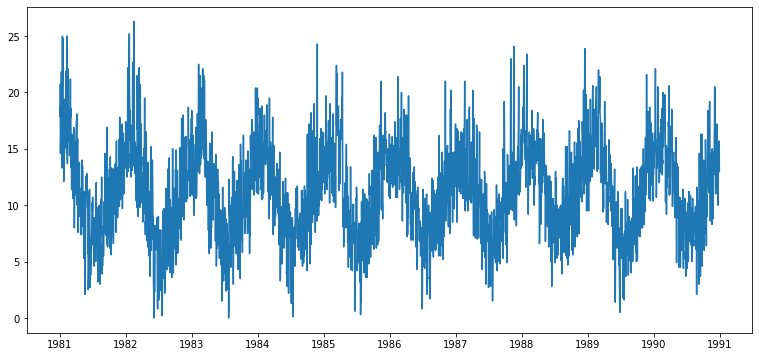

In [9]:
# 결측치 보간. 기준은 time
ts1 = ts1.interpolate(method='time')

# 결측치 재확인
print(ts1[ts1.isna()])

plt.plot(ts1)

In [10]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
  # 이동 평균 시계열
  rolmean = timeseries.rolling(window=window).mean()
  # 이동 표준편차 시계열
  rolstd = timeseries.rolling(window=window).std()
  # 원본, 이동평균, 이동표준편차를 plot
  orig = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')

  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

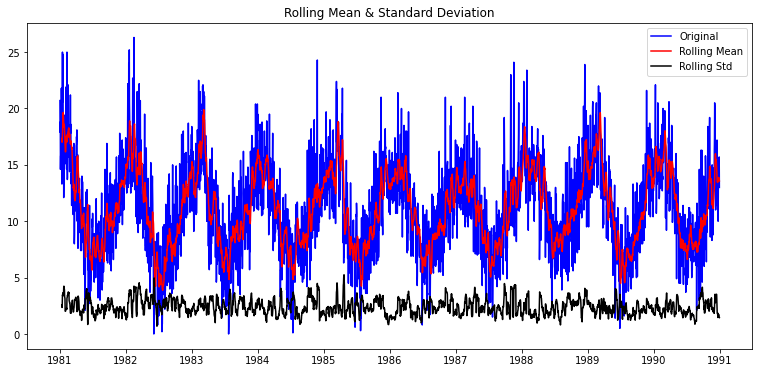

In [11]:
plot_rolling_statistics(ts1, window=12)

## International airline passengers

In [12]:
dir_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E14_stock_prediction/data/airline-passengers.csv'

df = pd.read_csv(dir_path, index_col='Month', parse_dates=True).fillna(0)

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


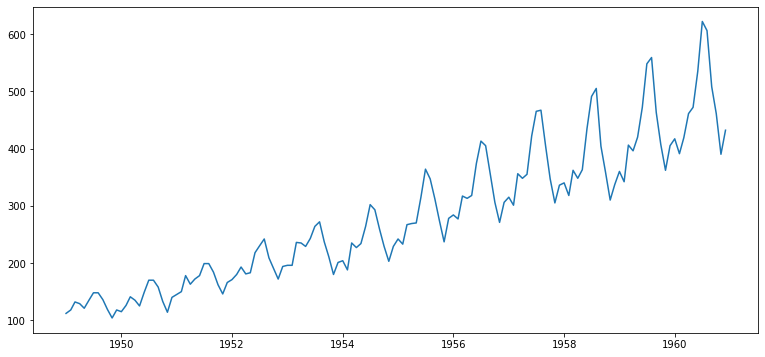

In [13]:
ts2 = df['Passengers']

plt.plot(ts2)

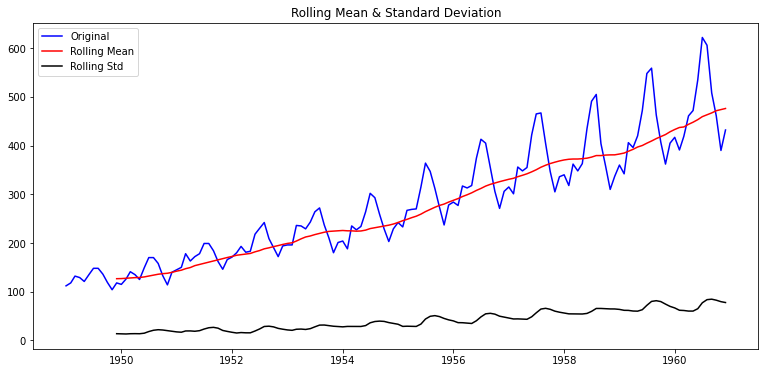

In [14]:
plot_rolling_statistics(ts2, window=12)

이렇게 시간의 추이에 따라 평균과 분산이 증가하는 패턴을 보인다면 이 시계열 데이터는 적어도 안정적이진 않다고 정성적인 결론을 내려볼 수 있을 것 같습니다.

시계열 데이터의 안정성을 시각화 방법을 통해 정성적으로 분석해 보았습니다. 이것은 시계열 데이터를 다루는 가장 기본적인 접근법이라 할 수 있습니다.

하지만 시계열 데이터의 안정성을 평가하는 데는 보다 정량적인 방법이 있습니다. 

## 시계열 안정성의 정량적 분석

### Augmented Dickey-Fuller Test

- 1) 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
- 2) 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우,
- 3) 이 시계열 데이터가 안정적이라는 대립가설(Alternative Hypothesis)을 채택하는 방법

- statsmodels 패키지의 adfuller 메서드를 사용해보자!


### p-value(유의확률)이란?

- 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률
- 0.05 미만이면 p-value 만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.

In [15]:
def augmented_dickey_fuller_test(timeseries):
  # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출한다.
  dftest = adfuller(timeseries, autolag='AIC')

  # adfuller 메서드가 리턴한 결과를 정리해 출력
  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

In [16]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64



Daily Minimum Temperatures in Melbourne 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 0에 가깝게 나타났습니다.

따라서 이 귀무가설은 기각되고, 이 시계열은 안정적 시계열이라는 대립가설이 채택됩니다.

In [17]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64



International airline passengers 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 1에 가깝게 나타났습니다.

이것이 바로 이 귀무가설이 옳다는 직접적인 증거가 되지는 않지만, 적어도 이 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없습니다.

## Stationary하게 만드는 방법?

- 1) 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도
- 2) 시계열 분해(Time series decomposition) 기법을 적용

### 1) 데이터 가공/변형하기


#### - 로그함수 변환

가장 먼저 고려해 볼 수 있는 것은 시간 추이에 따라 분산이 점점 커지고 있다는 점입니다. 시계열이 이런 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 됩니다.

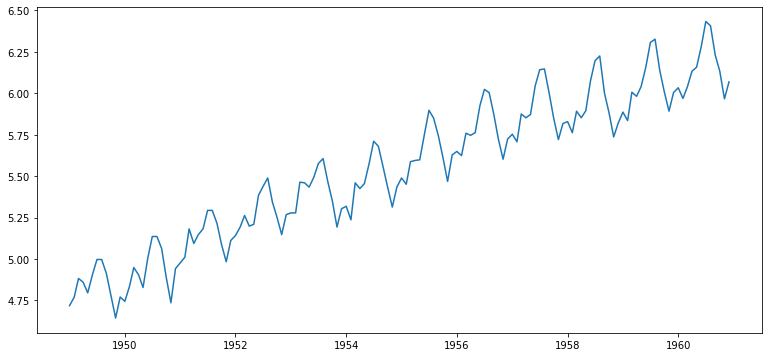

In [18]:
ts_log = np.log(ts2)

plt.plot(ts_log)

In [19]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value가 0.42로 무려 절반 이상 줄어들었습니다. 정성적으로도 시간 추이에 따른 분산이 일정해진 것을 확인할 수 있습니다.

하지만 아직 시간 추이에 따라 평균이 계속 증가한다는 문제가 있습니다.

#### - Moving average 제거 - 추세(Trend) 상쇄하기

- 시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다.
- 이 변화량을 제거하기 위해, 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼줍니다.

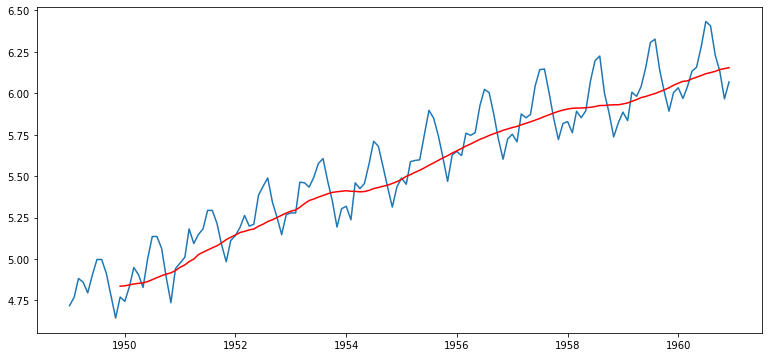

In [20]:
moving_avg = ts_log.rolling(window=12).mean()

plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [21]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생합니다.

이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 데이터셋에서 제거해 줍니다.

In [22]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

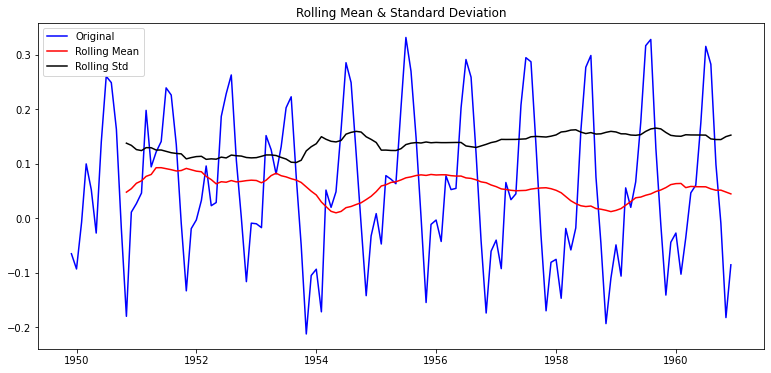

In [23]:
plot_rolling_statistics(ts_log_moving_avg)

In [24]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


드디어 p-value가 0.02 수준이 되었습니다.
95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있겠습니다.

그러나 지금까지의 접근에서는 Moving Average를 계산하는 window=12로 정확하게 지정해 주어야 한다는 문제가 있습니다. 만약 위 코드에서 window=6을 적용하면 어떤 결과가 나올까요?

In [25]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

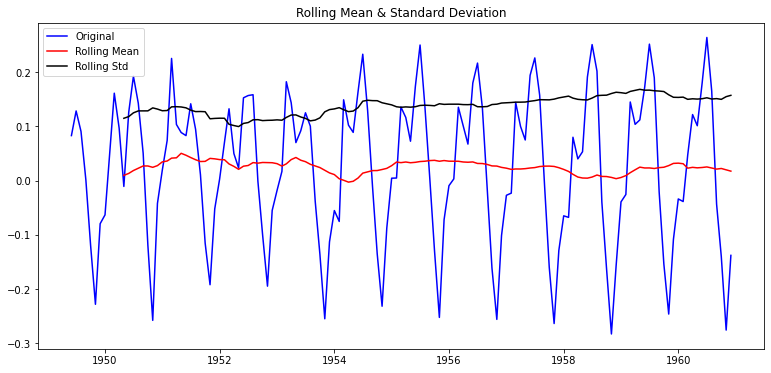

In [26]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [27]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


그래프를 정성적으로 분석해서는 window=12일 때와 별 차이를 느낄수 없지만 Augmented Dickey-Fuller Test의 결과 p-value는 0.18 수준이어서 아직도 안정적 시계열이라고 말할 수 없게 되었습니다.

이 데이터셋은 월 단위로 발생하는 시계열이므로 12개월 단위로 주기성이 있기 때문에 window=12가 적당하다는 것을 추측할 수도 있을 것 같습니다만,

moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 것을 기억해 둡시다.

#### - 차분(Differencing) - 계절성(Seasonality) 상쇄하기

Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다.

이것은 Moving Average 제거로는 상쇄되지 않는 효과입니다. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 합니다.

이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분(Differencing)이 있습니다.

마치 미분(Differentiation)을 떠올리게 하는 개념인데요.
시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법입니다.

이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 됩니다.

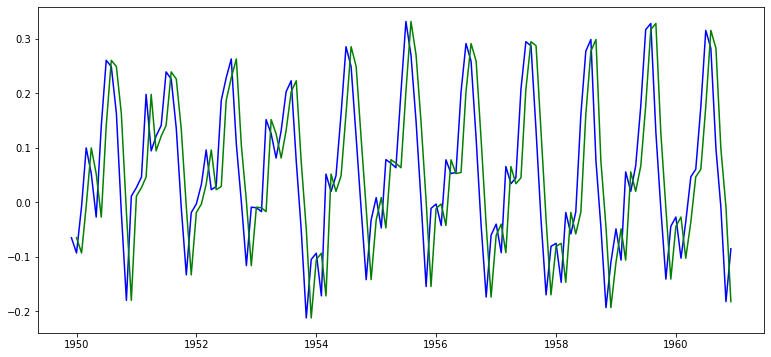

In [28]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

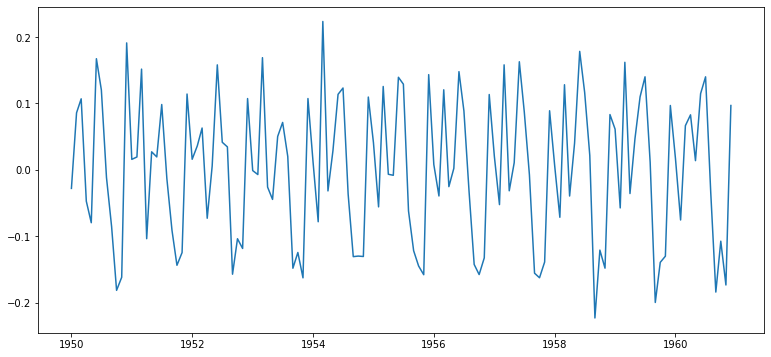

In [29]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift

ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

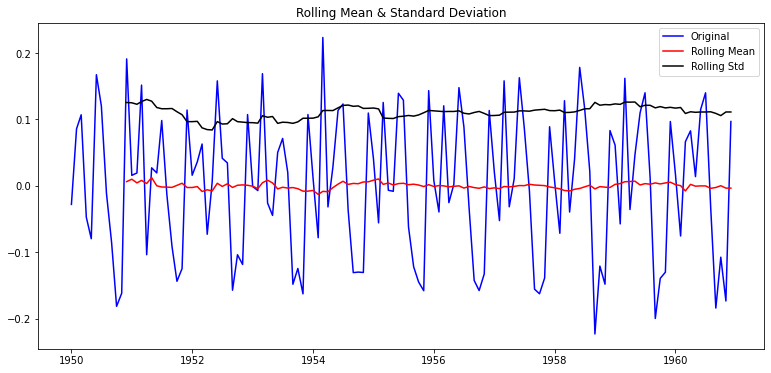

In [30]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [31]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


Trend를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, p-value가 이전의 10% 정도까지로 줄어들었습니다.

데이터에 따라서는 2차 차분(2nd order differencing, 차분의 차분), 3차 차분(3rd order differencing, 2차 차분의 차분)을 적용하면 더욱 p-value를 낮출 수 있을지도 모릅니다.

## 시계열 분해(Time series decomposition)

statsmodels 라이브러리 안에는 seasonal_decompose 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다.

이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 됩니다.

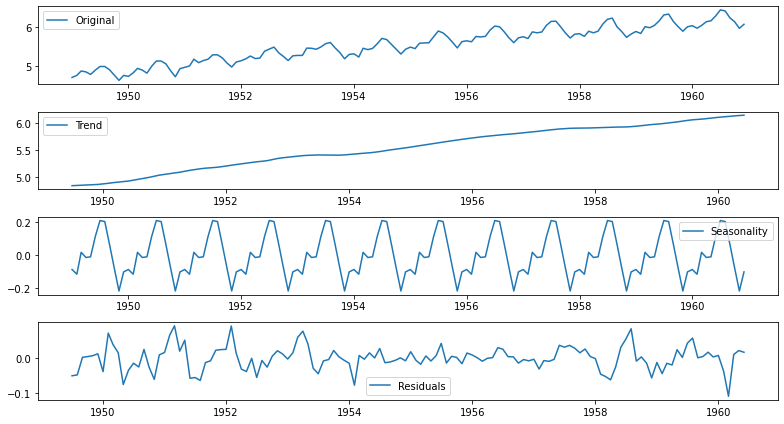

In [32]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다.

뒤집어서 말하면 Trend + Seasonality + Residual = Original 이 성립한다는 뜻입니다. 그렇다면 이제 Residual에 대해 안정성 여부를 따져 봅시다.

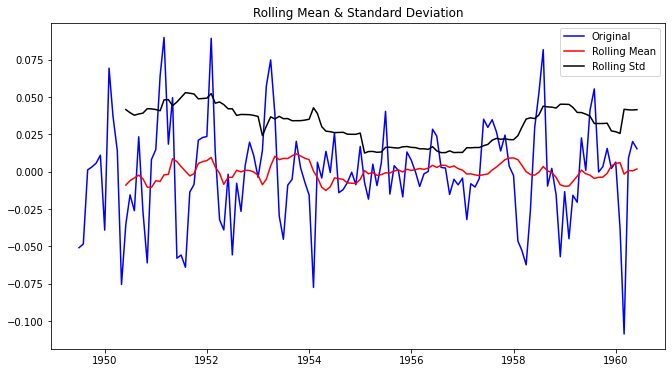

In [33]:
plot_rolling_statistics(residual)

In [34]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.

<hr>

# ARIMA 모델

## 1. 정의

- Autoregressive Integrated Moving Average = AR + I + MA
- 1) AR(자기 회귀)
    - 과거 값들에 대한 회귀로 미래 값을 예측하는 방법
    - 시계열의 residual에 해당하는 부분을 모델링한다고 볼 수 있다.

- 2) MA(이동 평균)
    - 시계열의 trend에 해당하는 부분을 모델링한다.
    - 예측 오차값이 0보다 크면 모델 예측보다 관측값이 더 높다는 뜻이므로, 다음 예측 시 예측치를 올려 잡는다.

- 3) I(차분 누적)
    - 시계열의 seasonality에 해당하는 부분을 모델링한다.


## 2. ARIMA 모델의 모수 p, q, d

- ARIMA의 파라미터는 3가지가 있다.
    - 1) p: 자기회귀 모형(AR)의 시차를 의미
    - 2) q: 이동평균 모형(MA)의 시차를 의미
    - 3) d: 차분(diffdrence) 횟수를 의미
- 모수 p,d,q는 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)을 통해 결정할 수 있습니다.
    - ACF 는 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
    - 즉 주어진 시계열의 현재 값이 과거 값과 어떻게 상관되는지 설명함
    - PACF 는 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
    - 즉 특정 시차 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도

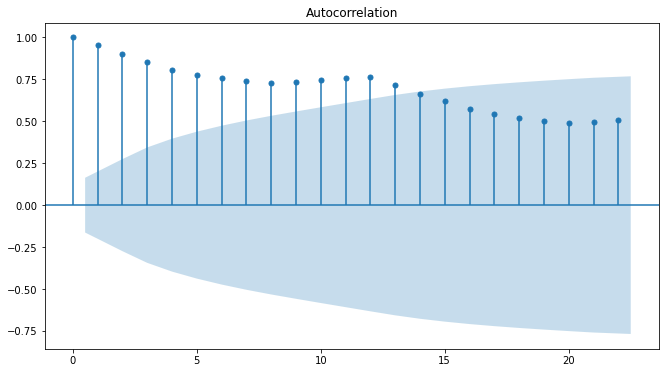

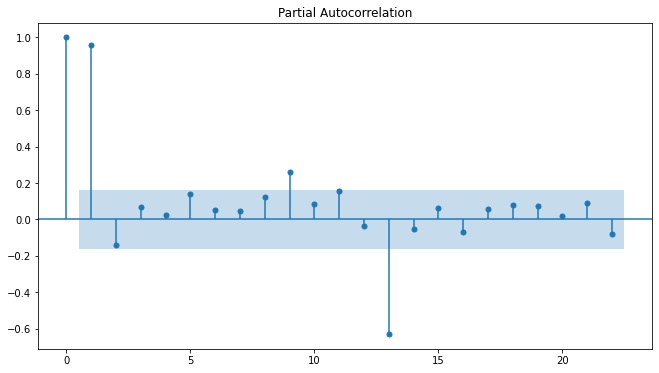

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

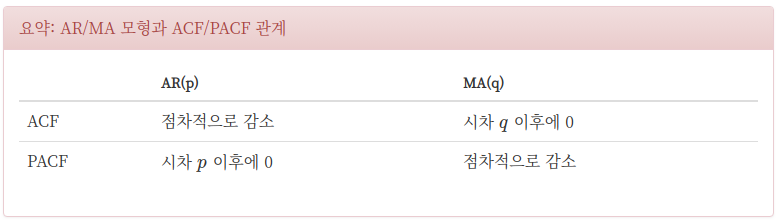

이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다.

p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.

반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다.

MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠습니다.

d를 구하기 위해서는 좀 다른 접근이 필요합니다. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 합니다.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


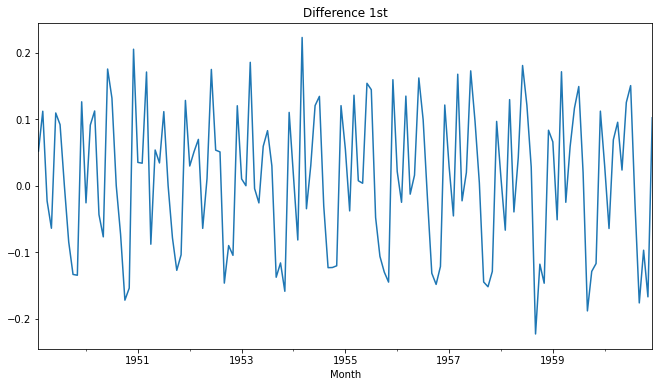

In [36]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


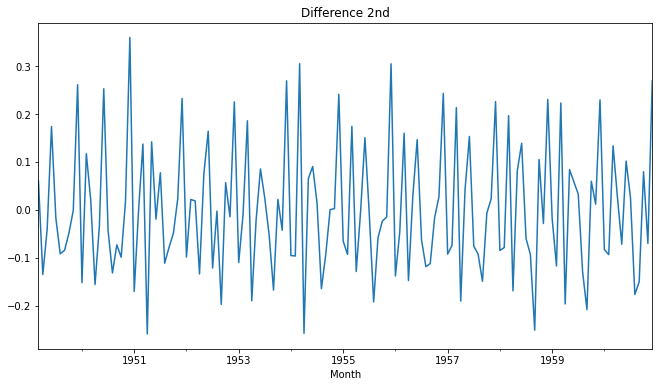

In [37]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

이번 경우에는 1차 차분을 구했을 때 약간 애매한 수준의 안정화 상태를 보였습니다.

2차 차분을 구했을 때는 확실히 안정화 상태였지만 이번 경우에는 d=1로 먼저 시도해 볼 수 있을 것 같습니다.

d 값도 바꿔 가면서 최적의 값을 찾아보기를 권합니다.

## 3. 학습 데이터 분리

- train:test = 9:1
- 시계열 예측이므로 가장 나중 데이터를 테스트용으로 사용

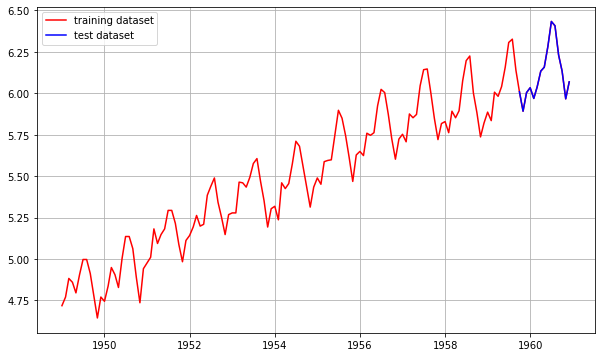

In [38]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [39]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


## 4. ARIMA 모델 훈련과 추론

위에서 우리는 일단 p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 우선적으로 고려하게 되었습니다.

In [40]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 108.023
Method:                       css-mle   S.D. of innovations              0.104
Date:                Sat, 04 Sep 2021   AIC                           -210.046
Time:                        14:57:44   BIC                           -201.490
Sample:                    02-01-1949   HQIC                          -206.570
                         - 09-01-1959                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0108      0.011      0.972      0.331      -0.011       0.033
ar.L1.D.Passengers     0.1754      0.088      1.994      0.046       0.003       0.348
                    

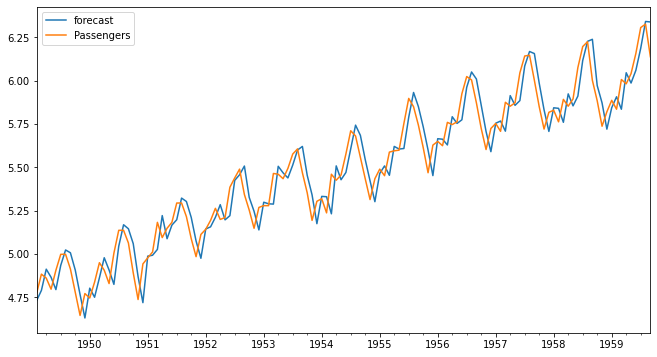

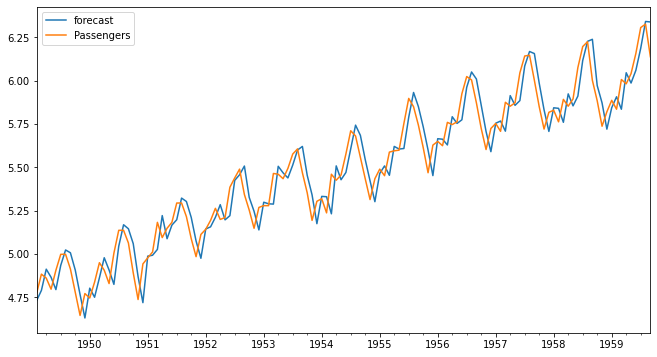

In [41]:
fitted_m.plot_predict()

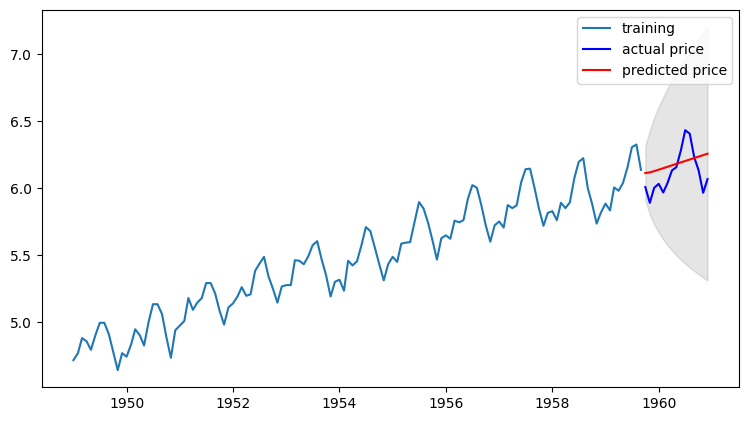

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [43]:
# 로그 변환된 시계열을 지수 변환하여 원본 스케일로 되돌리고 모델의 오차율 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5409.54978246723
MAE:  63.13692082580771
RMSE:  73.54964162025013
MAPE: 14.08%



최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 14% 정도의 오차율을 보입니다.

썩 만족스럽지 않은데, 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을지 모르겠습니다.

q=8을 줄 경우 MAPE가 10% 정도로 내려갑니다.
q=12를 쓸 수 있다면 더욱 좋을 거라는 예상이 되지만 이번 경우에는 데이터셋이 너무 작아 쓸 수 없었습니다.